In [1]:
# !pip install gekko
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import json
from lib import *

In [2]:
%load_ext autoreload
%autoreload 2

### Optimal Control

* $x$ - state value
* $u$ - control variable
* $t$ - time variable $\in [t_0, t_f] = N$ - time horizon

**Continuous time**: \
Cost function: $F(\cdot) = V_f(x(t_0), t_0, x(t_f), t_f) + \int\limits_{t_0}^{t_f} l(x(t), u(t), t) dt$
* State equation: $\dot{x} = f(x, u)$
* Path constraints: $h(x(t), u(t), t) \leq 0$
* Final constraint: $h_f(x(t_f)) \leq 0$


**Discrete time**: (in this case we renote: $t \in [t_0, t_f] \mapsto k \in [0, N]: x(t) = x(k)$)\
Cost function: $F(\cdot) = V_f(x(0), x(N)) + \sum\limits_{k=0}^{N} l(x(k), u(k))$
* State equation: $x^{+} = x(k+1) = f(x(k), u(k))$
* Path constraints: $h(x(k), u(k)) \leq 0$
* Final constraint: $h_f(x(N)) \leq 0$

### Mixed-Integer Optimal Control

Suppose we have
* $x \in \mathbb{R}^{n_x}$ - state variable
* $u \in \mathbb{R}^{n_u}$ - continuous control variable
* $i \in \mathbb{Z}^{n_i}$ - integer control variable inside a bounded convex polyhedron P
* Objective function $F$ consists of a nonlinear least squares term $F1$ and nonlinear term $F_2$ - both are differentiable

And lets note
* $\textbf{x} = (x(0), x(1), \dots, x(N))$
* $\textbf{u} = (u(0), u(1), \dots, u(N-1))$
* $\textbf{i} = (i(0), i(1), \dots, i(N-1))$

So we have **Mixed-Integer Optimal Control** problem ($\star$):

$
\min\limits_{\textbf{x}, \textbf{u}, \textbf{i}}
{F(\textbf{x}, \textbf{u}, \textbf{i})}, \quad
\left\{ \begin{array}{l}
x(0) = x_0 \\
x(k+1) = f(x(k), u(k), i(k)) \\
h(x(k), u(k), i(k)) \leq 0, k < N \\
h_f(x(N)) \leq 0 \\
\textbf{i} \in P \\
\textbf{i} \in \mathbb{Z}^{N \cdot n_i}
\end{array} \right.
\;\; $ and 
$
\;\; 
\left\{ \begin{array}{l}
F(\textbf{x}, \textbf{u}, \textbf{i}) = 
V_f(x(N)) + \sum\limits_{k=0}^{N} l(x(k), u(k), i(k)) \\
\left. \begin{array}{l}
l(x, u, i) = 
\frac{1}{2} \|l_1(x, u, i)\|_2^2 + l_2(x, u, i) \\
V_f(x) = 
\frac{1}{2} \|V_1(x)\|_2^2 + V_2(x)
\end{array} \right\}
\Rightarrow
F(\textbf{x}, \textbf{u}, \textbf{i}) = 
\frac{1}{2} \|F_1(x, u, i)\|_2^2 + F_2(x, u, i) \\
\end{array} \right.
$

---

**Example**

$
\begin{array}{rll}
\text{continuous time}: & 
    \dot{x}(t) = f_c(x(t), i(t)) = x^3(t) - i(t) \\
\text{discrete time}: & 
    x^{+} = x(k+1) = f(x(k), i(k)) = \text{Runge-Kutta-4}\ (f_c)
\end{array}
$

$
\text{objetive function}:
F(\textbf{x}, \textbf{i}) = \frac{1}{2} \sum\limits^{N}_{k=0} (x(k) - x_{ref})^2
$

<!-- $
P = 
\left\{ \textbf{i} \in [0, 1]^N \mid \begin{align} 
    & i(k) \geq i(k-1) - i(k-2) \\
    & i(k) \geq i(k-1) - i(k-3) 
\end{align} \right\}
$ -->

$
\textbf{MINLP}: 
\min\limits_{\textbf{x}, \textbf{i}}
F(\textbf{x}, \textbf{i}), \quad
\text{such that} \;\;
\left\{ \begin{array}{l}
x(0) = x_0 \\
x(k+1) = f(x(k), i(k)) \\
\textbf{i} \in P \cap \mathbb{Z}^{N} \\
\end{array} \right.
$

$N = 30, \ x_0 = 0.8, \ x_{ref} = 0.7$

---
Firtsly, let's solve it ($\star$) with existing MINL optimal control solver from GEKKO:

In [3]:
# Differential equation:
def f_right(x, u, i):
    return x ** 3 - i

def f(x, u, i):
    return x.dt() - f_right(x, u, i)

# Path inequality constraints:
def h(x, u, i):
    return x - x

# # Final inequality constraint:
# def h_f(x):
#     return x - x

# # Path cost function:
# def l(x, u):
#     return x ** 2 

# # Final cost function:
# def V_f(x):
#     return x ** 2

# Objective function
def F(x, u, i):
    return x ** 2

In [9]:
N = 30
time_step = 0.05
x_0 = 0.8
x_ref = 0.7

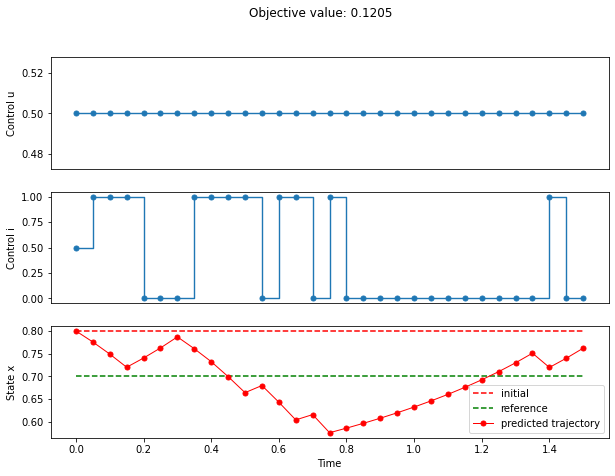

In [14]:
# history_minlp = run_optimal_control(x_0, x_ref, N, time_step, f, h, F, integer=True)
show_results(history_minlp)

Check that the requirement of the differential equation is met ($\dot{x}[k] = f(x[k], u[k])$)

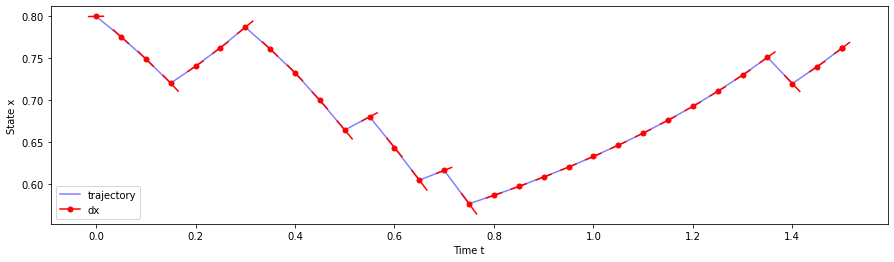

In [17]:
dt = time_step * 0.3
dx = f_right(np.array(history_minlp['x']), 
             np.array(history_minlp['u']), 
             np.array(history_minlp['i'])) * dt
t_x_dx = zip(history_minlp['time'], history_minlp['x'], dx)

plt.figure(figsize=(15, 4))
plt.plot(history_minlp['time'], history_minlp['x'], c='b', alpha=0.5, label='trajectory')
plt.ylabel('State x')
plt.xlabel('Time t')

for t, x, dx in t_x_dx:
    t_point = [t - dt, t + dt]
    x_point = [x - dx, x + dx]
    plt.plot(t_point, x_point, c='r')
    plt.plot(t, x, '-o', c='r', markersize=5)
plt.plot(t, x, '-o', c='r', markersize=5, label='dx')

plt.legend()
plt.show()

As we can see, the requiremnt is met, so the solution is correct.

### Gauss-Newton algorithm

Now we can try to solve it ($\star$) with the Gauss-Newton algorithm:

**S1**: solve it without integrality constraint $\textbf{i} \in \mathbb{Z}^{n_i}$:

$
(\textbf{x}^*, \textbf{u}^*, \textbf{i}^*) = \arg\min\limits_{\textbf{x, u, i}}{F(\textbf{x, u, i})}, \quad
i \in P
$

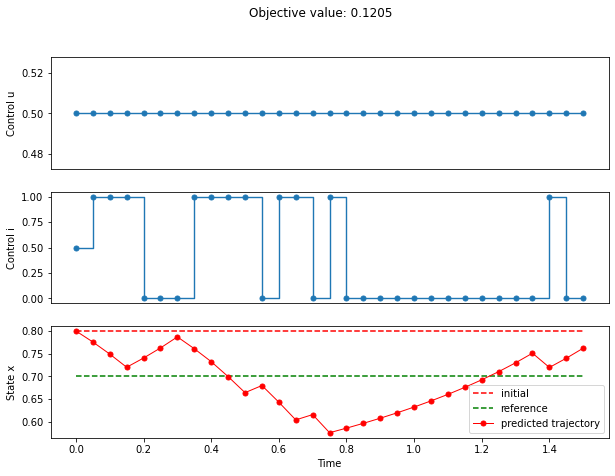

In [18]:
history_nlp = run_optimal_control(0.8, 0.7, 30, 0.05, f, h, F, integer=True)
show_results(history_nlp)

**S2**: approximate our continuous solution by an integer one

Denote for a notation simplification:

* $z = (\textbf{x}, \textbf{u}) \in \mathbb{R}^{n_z}$, where $n_z = (N+1) \cdot n_x + N \cdot n_u$ - continuous variable
* $y = \textbf{i} \in \mathbb{R}^{n_y}$, where $n_y = N \cdot n_u$ - integer variable

then we have **Mixed-Integer Non Linear Programming** problem ($\star\star$) instead of **Mixed-Integer Non Linear Optimal Control** one ($\star$):

$
\min\limits_{y, z}{F(y, z)}, \quad
\left\{ \begin{array}{l}
G(y, z) = 0 
\;\; \text{instead of} \;
\left\{ \begin{array}{l}
x(0) = x_0 \\
x(k+1) = f(x(k), u(k), i(k))) 
\end{array} \right. \\
H(y, z) \leq 0
\;\; \text{instead of} \;
\left\{ \begin{array}{l}
h(x(k), u(k), i(k)) \leq 0, k < N \\
h_f(x(N)) \leq 0
\end{array} \right. \\
y \in P \cap \mathbb{Z}^{n_y}
\end{array} \right.
\;\; $

So, after the first step (S1) we have a continuous solution 
$(\textbf{x}^*, \textbf{u}^*, \textbf{i}^*) = (z^*, y^*)$, where $y^* = \textbf{i}^* \in P$. And we want to approximate the continuous solution $y^*$ by the integer solution $y^{**}$:

$
y^{**} = \arg\min\limits_{y}{d(y, y^*)}, \quad
y \in P \cup Z^{n_y}
$

**Gauss-Newton**:

$d(y, y^*) = J_{GN}(y \mid y^*, z^*) - J_{NLP}(y^*)$, where

$J_{GN}(y \mid y^*, z^*) = J_{QP}(y \mid y^*, z^*, B_{GN}(y^*, z^*))$, where 

$
J_{QP}(y \mid y^*, z^*, B) =
\min\limits_{z}{F_{QP}(y, z \mid y^*, z^*, B)}, \quad
\left\{ \begin{array}{l}
G_L(y, z \mid y^*, z^*) = 0 \\
H_L(y, z \mid y^*, z^*) \leq 0 \\
\end{array} \right.
$ where

* $
    B_{GN}(y^*, z^*) = 
    \frac{\partial F_1}{\partial (y, z)}(y^*, z^*)
    (\frac{\partial F_1}{\partial (y, z)}(y^*, z^*))^T
  $

* $
    F_{QP}(y, z \mid y^*, z^*, B) = 
    F_L(y, z \mid y^*, z^*) + 
    \frac{1}{2} 
    \begin{bmatrix} y - y^* \\ z - z^* \end{bmatrix}^T
    B
    \begin{bmatrix} y - y^* \\ z - z^* \end{bmatrix}
  $
* $
   F_{L}(y, z \mid y^*, z^*) = 
   F(y^*, z^*) + \frac{\partial F}{\partial (y, z)}(y^*, z^*)
   ((y, z) - (y^*, z^*))
  $
* $
   G_{L}(y, z \mid y^*, z^*) = 
   G(y^*, z^*) + \frac{\partial G}{\partial (y, z)}(y^*, z^*)
   ((y, z) - (y^*, z^*))
  $
* $
   H_{L}(y, z \mid y^*, z^*) = 
   H(y^*, z^*) + \frac{\partial H}{\partial (y, z)}(y^*, z^*)
   ((y, z) - (y^*, z^*))
  $

But in practice of working with GEKKO it will be better to return to an Optimal Control formulation:

$
\textbf{i}^{**} = 
\arg\min\limits_{\textbf{i}}{
d(\textbf{i}, \textbf{i}^{*})
}, \quad
\left\{ \begin{array}{l}
x(0) = x_0 \\
x(k+1) = f_L(x(k), u(k), i(k)) \\
h_L(x(k), u(k), i(k)) \leq 0, k < N \\
h_{fL}(x(N)) \leq 0 \\
\textbf{i} \in P \cap \mathbb{Z}^{N \cdot n_i}
\end{array} \right.
$

<!-- Now our  problem just is a **MINL Programming** problem.


Suppose we have 

* $z \in \mathbb{R}^{n_z}$ - continuous variable
* $y \in \mathbb{R}^{n_y}$ - integer variable

So we have :



**Proposal three-step algorithm**:

$
J_{NLP}(y) = \min\limits_{z}{F(y, z)}, \quad
\left\{ \begin{array}{l}
G(y, z) = 0 \\
H(y, z) \leq 0 \\
\end{array} \right.
$

**S1**:
$
(y^*, z^*) = \arg\min\limits_{y}{J_{NLP}(y)}, \quad
y \in P
$

**S2**:
$
y^{**} = \arg\min\limits_{y}{d(y, y^*)}, \quad
y \in P \cup Z^{n_y}
$

**S3**:
$
z^{***} = \arg J_{NLP}(y^{**}) = \arg\min\limits_{z}{F(y^{**}, z)}, \quad
\left\{ \begin{array}{l}
G(y, z) = 0 \\
H(y, z) \leq 0 \\
\end{array} \right.
$

$d(y, y^*) = \|y - y^*\|$ -->

In [26]:
def approx_fprime(xk, f, eps, *args):
    print('-'*50)
    print(type(xk))
    f0 = f(xk, *args)
    print(f0)
    return optimize._numdiff.approx_derivative(f, xk, method='2-point', abs_step=eps, args=args, f0=f0)

def linear(f, x, u, x0, u0):
    print(type(x))
    print(type(u))
    print(type(x0))
    print(type(u0))
    f_x = lambda t: f(t, u0)
    f_u = lambda t: f(x0, t)
    f_grad_x = approx_fprime(x0, f_x, 1e-6)
    f_grad_u = approx_fprime(u0, f_u, 1e-6)
    f_grad = np.array([f_grad_x, f_grad_u])
    
#     f_ = lambda x: f(*x)
#     f_grad = optimize.approx_fprime((x0, u0), f_, 1e-6)
#     delta = (np.array([x, u]) - np.array([x0, u0]))
#     return f_(x0, u0) + f_grad @ delta
linear(G, x, u, x_ref, u_ref)

<class 'gekko.gk_variable.GKVariable'>
<class 'gekko.gk_variable.GKVariable'>
<class 'gekko.gk_variable.GKVariable'>
<class 'gekko.gk_variable.GKVariable'>
--------------------------------------------------
<class 'gekko.gk_variable.GKVariable'>
(($v2-((v2)^(3)))+((3)*(v1)))


AttributeError: 'numpy.ndarray' object has no attribute 'dt'

In [141]:
z_nlp = history_nlp['x']
y_nlp = history_nlp['u']
obj_nlp = history_nlp['obj']

In [144]:
m = GEKKO(remote=False)
m.options.IMODE=2

u_ref = m.Var(u_nlp); m.fix(u_ref)
x_ref = m.Var(x_nlp); m.fix(x_ref)

u = m.Var(u_nlp, integer=True)
x = m.Var(x_nlp)

def g(x, u):
    return x[1:] - x ** 3 - u[1:]

def f(u, u_ref):
    return (u - u_ref) ** 2

m.Obj(g(x, u))

m.Minimize(f(u, u_ref) - obj_nlp)
m.solve(disp=False)
print(u.value)

Exception: @error: Model Expression
 *** Error in syntax of function string: Missing operator
 
Position: 14                  
 0.78099999657,0.11433333875,0.11433333319,0.11433333149,0.11433333334,0.11433333333,0.11433333334,0.11433333334,0.11433333333,0.11433333334,0.11433333334,0.11433333333,0.11433333334,0.11433333333,0.11433333333,0.11433333333,0.11433333334,0.11433333333,0.11433333333,0.11433333334,0.11433333333,0.11433333334,0.11433333333,0.11433333333,0.11433333334,0.11433333333,0.11433333333,0.11433333333,0.11433333381,0.11433333235
              ?



In [199]:
# Linearization of the function f
def linear(f, x, u, x0, u0):
#     f_x = lambda x: f(x, u0)
#     f_u = lambda u: f(x0, u)
#     f_grad_x = optimize.approx_fprime(x0, f_x, 1e-6)
#     f_grad_u = optimize.approx_fprime(u0, f_u, 1e-6)
#     f_grad = np.array([f_grad_x, f_grad_u])
    
    f_ = lambda x: f(*x)
    f_grad = optimize.approx_fprime((x0, u0), f_, 1e-6)
    delta = (np.array([x, u]) - np.array([x0, u0]))
    return f_(x0, u0) + f_grad @ delta

# Quadratization of the function f
def quadratic(f, x, u, x0, u0, B):
    f_linear = linear(f, x, u, x0, u0)
    delta = (np.array([x, u]) - np.array([x0, u0]))
    return f_linear + 0.5 * delta.T @ B @ delta

# Gaussian-Newton Hessian approximation 
def b_gn(f, x, u, x0, u0):
    f_grad = optimize.approx_fprime((x0, u0), f, 1e-6)
    return np.outer(f_grad, f_grad)

# Positive semidefinition checking 
def pos_semidef(B):
    return np.all(np.linalg.eigvals(B) >= 0)

# Gauss-Newton method
def gauss_newton(f, f1, x, u, x0, u0):
    B_GN = b_gn(f1, x, u, x0, u0)
    print(f'Pos.semidef.: {pos_semidef(B_GN)}')
    return quadratic(f, x, u, x0, u0, B_GN)

In [200]:
G_L  = lambda x, u, x0, u0: linear(G, x, u, x0, u0)
H_L  = lambda x, u, x0, u0: linear(H, x, u, x0, u0)
F_QP = lambda x, u: gauss_newton(F, F1, x, u, x0, u0)
F_GN = lambda x, u: F_QP(x, u) - obj_nlp

In [139]:
# m = GEKKO(remote=False)                  # Initialize gekko
# m.options.SOLVER = 1 # if integer else 3   # Define the solver

# # Continuous variables
# x = [m.Var(value=x_i) for x_i in x_nlp]
# x_nlp = [m.Const(value=x_i) for x_i in x_nlp]
# u = [m.Var(value=u_i, integer=True, lb=0, ub=1) for u_i in u_nlp]
# u_nlp = [m.Const(value=u_i) for u_i in u_nlp]

# for i in range(N):
#     print(x[i], u[i], x_nlp[i], u_nlp[i])
#     m.Equation(G_L(x[i], u[i], x_nlp[i], u_nlp[i]) == 0) # G function
#     m.Equation(H_L(x[i], u[i], x_nlp[i], u_nlp[i]) <= 0) # H function

# # Objective
# m.Obj(sum(F(x[i], u[i]) for i in range(N)))

# # m.solve()#disp=False, debug=0)